In [1]:
#Let us UPLOAD the desired libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import math
from matplotlib.animation import FuncAnimation
np.set_printoptions(precision=15, suppress=False) #stablish the output number of decimals
import scipy.special as sp
import scipy.signal as signal
from scipy.optimize import root
!pip install numdifftools #necessary to compute numerical derivatives

## Computation of Neural System ODEs: E-I with an inhibitory input 

In [2]:
# The parameters we consider are as follows. For their biological significance, please refer to the thesis.
tau_e = 8
tau_i = 8
tau_se = 1
tau_si = 5
Jee = 0
Jii = 0
Jie = 13
Jei = 13
Delta_e = 1
Delta_i = 1
eta_e = -5
eta_i = -5
I_bar_e = 10
I_bar_i = 0

# Initial condition: Taken from "Communication through coherence in a realistic neuronal model" by David Reyner Parra.
x0_david = [0.085262756825722,
1.125737037325799,
0.000000000000000,
0.209748707974244,
0.012828206758546,
-1.136491592341226,
0.834230210263032,
0.000000000000000]

# Neural network system of ODEs for the unperturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network_notperturbed(x, t):

    # Compute the total external input to the neurons
    I_e = I_bar_e + tau_e * x[2] - tau_e * x[3]
    I_i = I_bar_i + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1/tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1/tau_e) * (x[1]**2 + eta_e + I_e - (tau_e * np.pi * x[0])**2),  # Ve
        (1/tau_se) * (-x[2] + Jee * x[0]),  # See
        (1/tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1/tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1/tau_i) * (x[5]**2 + eta_i + I_i - (tau_i * np.pi * x[4])**2),  # Vi
        (1/tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1/tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt

In [3]:
# The following code implements the Poincaré section. 
#The theoretical background is explained in the appendix of the thesis.


def g(x):
    return x[1]

def approximation_tau_dir(system,x0,g,atol,rtol,dir, plot,estimated_period):
  if dir == 1 : t = np.linspace(0, estimated_period, 500)
  elif dir == -1 : t = np.linspace(0, -estimated_period, 500)
  sol_simp = odeint(system, x0, t,atol=atol, rtol=rtol)
  x_i=sol_simp[1]
  for i, xi in enumerate(sol_simp[1:], start=1):  # We do not consider the first element (to avoid problems if x0 belongs to Sigma)
        if g(x_i) * g(xi) <= 0:  # Verify if the product changes sign or is equal to zero
            t0 = t[i]  # Time correponding to the crossing value
            #print(xi)  # Print the point where the crossing occurs
            break
        x_i = xi  # Update the value of x_i

  if plot == 1:
    # Plot the solution in the xy-plane
    plt.figure(figsize=(4, 4))
    plt.plot(sol_simp[:,0], sol_simp[:,1])
    plt.xlabel('$r_e$ (kHz)')
    plt.ylabel('$V_e$ (mV)')
    plt.title('Peridic oscillator ')
    plt.grid(True)
    plt.show()


  return [xi,t0]

# One iteration of Newton's method
def DeltaT(x0):
    I_e = I_bar_e + tau_e * x0[2] - tau_e * x0[3]
    Ve=(1/tau_e) * (x0[1]**2 + eta_e + I_e - (tau_e * np.pi * x0[0])**2)
    return - g(x0) / Ve

# Function to evaluate the system's solution at a given direction and time
def evaluate(system, x0, h, dir, atol, rtol):
    if dir == 1: t = np.linspace(0, h, 100)  # Small time step. Forward integration
    if dir == -1 : t = np.linspace(0, -h, 100) # Backward integration
    sol = odeint(system, x0, t, atol=atol, rtol=rtol)
    return sol[-1]

def poincare_map_n_periodic(system, x0,n, tol, atol, rtol,dir,plot,estimated_period):
    points = np.zeros((n, 8))  # To store intersection points
    X0=x0
    total_time = 0
    for i in range(n):
        # Use last intersection point as new initial condition
      if i != 0: x0 = xk
      approx = approximation_tau_dir(neural_network_notperturbed,x0,g,atol,rtol,dir,plot,estimated_period)
      xk = approx[0]
      total_time += approx[1]

      # Refine the intersection using Newton's method
      while abs(g(xk)) > tol:
            deltaT = DeltaT(xk)
            total_time += deltaT
            if deltaT < 0:
                  xk = evaluate(system, xk, abs(deltaT), -1, atol, rtol)
            else:
                  xk = evaluate(system, xk, abs(deltaT), 1, atol, rtol)
      points[i, :] = xk  # Store the refined intersection point

    return points,total_time, points[-1]


In [4]:
# The following code is used to find a point that belongs to the oscillator and calculate its period T*.


t = np.linspace(0, 350, 2500)
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, x0_david, t, atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 300  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)

# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
x0=sol[-1]

P_0= poincare_map_n_periodic(neural_network_notperturbed, x0,1, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[2]

def Poincare(x):
    result = poincare_map_n_periodic(
        neural_network_notperturbed,
        x,
        n=2,
        tol=tol,
        atol=atol,
        rtol=rtol,
        dir=1,
        plot=0,
        estimated_period=estimated_period
    )[2]-x
    return result

# Find the root of the Poincaré map
result = root(Poincare, P_0,method='hybr')

# Check and display the result of the root-finding process
if result.success:
    print(f"Root found: {result.x}")
else:
    print("No root found.")

P_1=result.x
Period = poincare_map_n_periodic(neural_network_notperturbed,P_1 ,2, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[1]
print(f"Period of the oscillator, T* = {Period}")

Root found: [ 2.464796620183146e-02  1.167705011074589e-23  4.732717671413217e-30
  2.970676711526801e-01  1.048186004864776e-02 -1.841054850356672e+00
  2.716710240600461e-01  0.000000000000000e+00]
Period of the oscillator, T* = 24.23496887842161


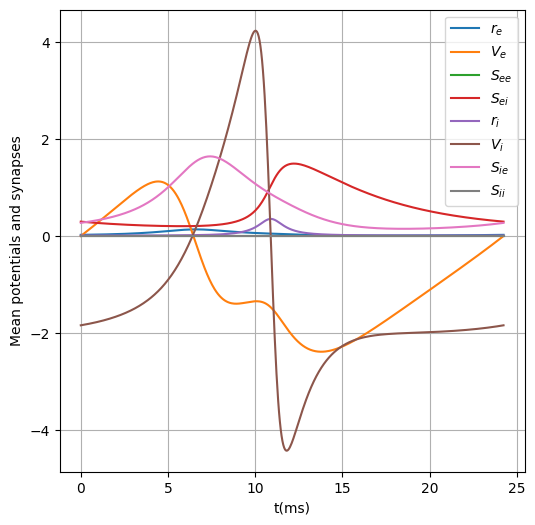

In [5]:
#Graphic representation of the oscillator
t = np.linspace(0, Period, 500)

# Parameters
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, P_1, t, atol=atol, rtol=rtol)


plt.figure(figsize=(6, 6))
plt.plot(t,sol[:,0],label=r'$r_e$')
plt.plot(t,sol[:,1],label=r'$V_e$')
plt.plot(t,sol[:,2],label=r'$S_{ee}$')
plt.plot(t,sol[:,3],label=r'$S_{ei}$')
plt.plot(t,sol[:,4],label=r'$r_i$')
plt.plot(t,sol[:,5],label=r'$V_i$')
plt.plot(t,sol[:,6],label=r'$S_{ie}$')
plt.plot(t,sol[:,7],label=r'$S_{ii}$')
plt.ylabel('Mean potentials and synapses')
plt.xlabel('t(ms)')
plt.grid(True)
plt.legend()
plt.show()

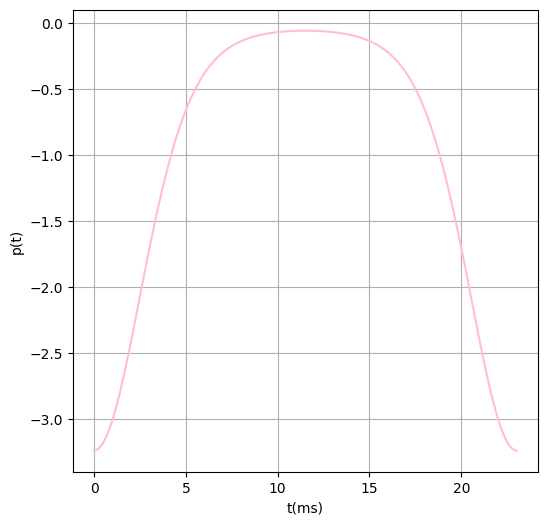

Estimated period of r_e (after transient): 22.515010006671105 seconds


In [17]:
#Define the inhibitory input with mu=0 and coherence kappa=2
mu = 0
k = 2

# External input function 
def p(t,T):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    return -T * (np.exp(k * np.cos(((2 * np.pi) * (t - mu)) / T))) / (T * I0_value)

vals_t=np.linspace(0,0.95*Period,100)
y = [p(val, 0.95*Period) for val in vals_t]  # Map values for y-axis


plt.figure(figsize=(6, 6))
plt.plot(vals_t, y, color='pink')
plt.ylabel('p(t)')
plt.xlabel('t(ms)')
plt.grid(True)
plt.show()




# Neural network system of ODEs for the perturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network(x, t,A,T):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * A * p(t,T)
    I_i_ext = I_bar_i + tau_i * A * p(t,T)

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt


# Time span for integration
t = np.linspace(0, 150, 1500)

# Solve the system of equations
atol = 1e-17
rtol = 1e-13

sol = odeint(neural_network, P_1, t, args =(0.2,23,), atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 100  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)
#print(t[peaks[-1]])
# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
print(f"Estimated period of r_e (after transient): {estimated_period} seconds")

### Phase equation


In [18]:
# The following code implements the definitions needed to compute the iPRC.

from scipy.interpolate import interp1d

# Jacobian of the system F(x)
def jacobian(x):
    # Jacobian matrix of the neural network system
    jacobian_matrix = np.zeros((8, 8))

    jacobian_matrix[0, 0] = (1 / tau_e) * (2 * x[1])  # df0/dx0
    jacobian_matrix[0, 1] = (1 / tau_e) * (2 * x[0])  # df0/dx1
    jacobian_matrix[1, 0] = (-2 * (np.pi**2)*x[0]*tau_e)  # df1/dx0
    jacobian_matrix[1, 1] = (1 / tau_e) * (2 * x[1])  # df1/dx1
    jacobian_matrix[1, 2] = 1  # df1/dx2
    jacobian_matrix[1, 3] = -1  # df1/dx3
    jacobian_matrix[2, 0] = (1 / tau_se) * Jee        # df2/dx0
    jacobian_matrix[2, 2] = (-1 / tau_se)       # df2/dx2
    jacobian_matrix[3, 3] = (-1 / tau_si)   # df3/dx3
    jacobian_matrix[3, 4] = (1 / tau_si) * Jei        # df3/dx4
    jacobian_matrix[4, 4] = (1 / tau_i) * (2 * x[5])  # df4/dx4
    jacobian_matrix[4, 5] = (1 / tau_i) * (2 * x[4])  # df4/dx5
    jacobian_matrix[5, 4] = (-2 * (np.pi**2)*x[4]*tau_i)  # df5/dx4
    jacobian_matrix[5, 5] = (1 / tau_i) * (2 * x[5])  # df5/dx5
    jacobian_matrix[5, 6] = 1 # df5/dx6
    jacobian_matrix[5, 7] = -1 # df5/dx7
    jacobian_matrix[6, 0] = (1 / tau_se) * Jie        # df6/dx0
    jacobian_matrix[6, 6] = (-1 / tau_se)         # df6/dx6
    jacobian_matrix[7, 4] = (1 / tau_si) * Jii        # df7/dx4
    jacobian_matrix[7, 7] = (-1 / tau_si)       # df7/dx7


    return -jacobian_matrix.T


# Define the matrix differential equation as a vector-valued function
def adjoint_equation(X_flat, t, interp_orbit):
    # Reshape the flat vector back into the matrix form (8x8 in this case)
    X = X_flat.reshape((8, 8))  # Adjust the shape for your matrix size

    # Interpolate the state x(t) from the periodic orbit at time t
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ X

    # Flatten the result back into a vector
    return dX_dt.flatten()


# Define the vectorial differential equation 
def vector_adjoint_equation(x, t, interp_orbit):
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ x

    # Flatten the result back into a vector
    return dX_dt

#INTEGRATION OF THE PHASE EQUATION
def phase_equation(x, t, interp_orbit_iPRC,A,T):
    z_t = interp_orbit_iPRC(x % Period)  # Interpolate z_t theta

    # Compute the phase equation (wrapped modulo Period)
    dtheta = 1 +  (z_t[1] + z_t[5]) * A * p(t,T)
    return dtheta



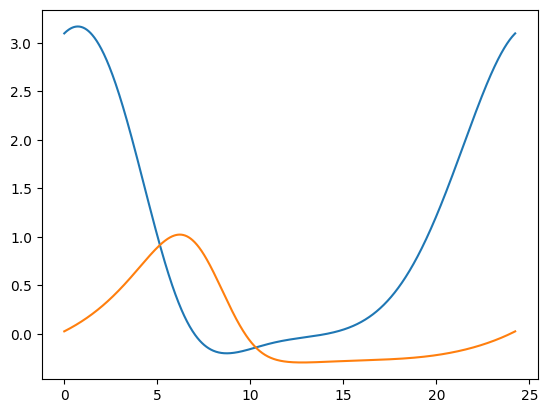

In [21]:
#ALL THIS COMPUTATITIONS ARE INTRINSIC OF THE OSCILLATOR (do not depend on theta,T,A)
# The following code implements the computation of the iPRC.

x_0 = P_1  # Initial condition for the periodic orbit (assumed to be defined)

t = np.linspace(0, Period, 1000)

# Integrate the periodic orbit
orbit_solution = odeint(neural_network_notperturbed, x_0, t, atol=atol, rtol=rtol)
interp_orbit_oscillator = interp1d(t, orbit_solution.T, kind='cubic', fill_value='extrapolate')

# Initial condition for the fundamental matrix (identity matrix)
A0 = np.eye(8).flatten()
t_vals = np.linspace(0, Period, 1000)

# Integrate the adjoint equation for the fundamental matrix
sol = odeint(adjoint_equation, A0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
A_T = sol[-1].reshape(8, 8)
eigenvalues, eigenvectors = np.linalg.eig(A_T)
print(eigenvalues)
real_eigenvalues = np.real(eigenvalues)
closest_index = np.argmin(np.abs(real_eigenvalues - 1))
v_0 = np.real(eigenvectors[:, closest_index])
alpha = 1 / (v_0 @ neural_network_notperturbed(x_0, 0))
V_0 = alpha * v_0

# Integrate the adjoint equation for the phase response curve
sol_phi_t = odeint(vector_adjoint_equation, V_0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
interp_orbit_iPRC = interp1d(t_vals, sol_phi_t.T, kind='cubic', fill_value='extrapolate')


plt.plot(t_vals,sol_phi_t[:,1],label=r'$iPRC-V_e$')
plt.plot(t_vals,sol_phi_t[:,5],label=r'$iPRC-V_i$')

t=np.linspace(0,Period,1000)
plt.plot(t,interp_orbit_iPRC(t)[1])



In [11]:
# Define the stroboscopic map function with updated parameters (x, A, T)
def stroboscopic_map(x, A, T,interp_orbit_iPRC):

    # Integrate the phase equation with the initial condition x
    t_phase = np.linspace(0, T, 1000)
    sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
    Theta_n = sol_theta_t[-1] % Period

    return Theta_n[0] #to ensure that it is an scalar



theta_n=18
#print(T/Period)
for i in range(1,50):
  theta_n=stroboscopic_map(theta_n,0.05,0.95*Period, interp_orbit_iPRC)
  print(theta_n)

15.632175817145665
13.414136767383084
11.189742336277732
8.811900407007307
6.249902914052598
3.5264167626987764
0.7950681587337236
22.29475644249934
19.591612792075928
17.081044222820587
14.785318227969569
12.584760013741572
10.31508509183515
7.866606329549953
5.23462644882763
2.4914964807316196
24.001612142738217
21.261854162426964
18.616080551124114
16.19414996177619
13.952390636045358
11.745277045378174
9.412962744307308
6.895836229853096
4.201327970598651
1.4625602902498684
22.968300825404867
20.242231411652064
17.674676640609114
15.333843842841787
13.12459555297523
10.886796838359253
8.484073323556316
5.897566421604498
3.1637453968986335
0.4357803662054387
21.93266259336592
19.24668618818314
16.76740112740005
14.492822311254315
12.292739361567364
10.00268811820549
7.5300393435704684
4.874541150469
2.1309945414079294
23.640734757985534
20.903099748720564
18.282813618651197
15.890543366691816


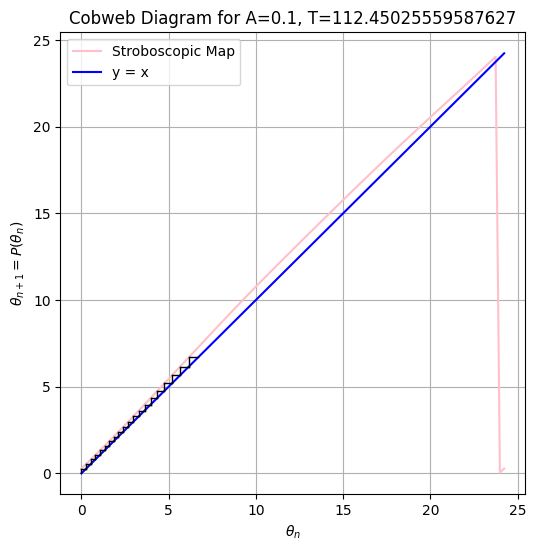

In [12]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot(0,4.64*Period, 0.1, 20)


### Computation of Arnold Tongues for $\kappa=\infty$

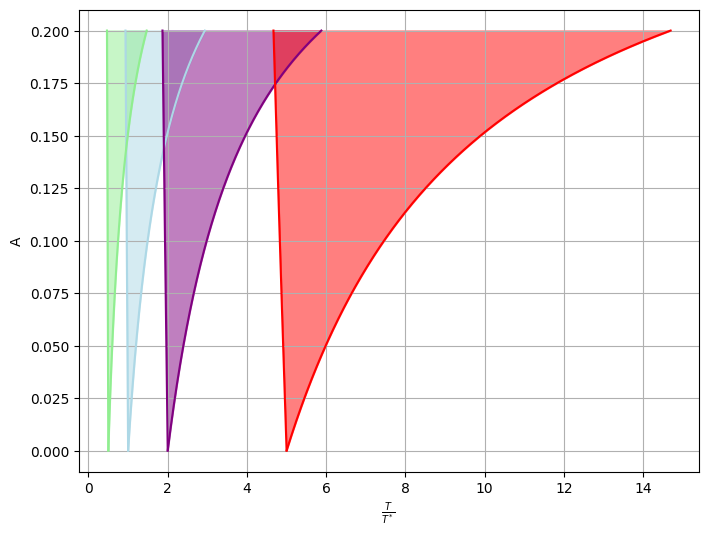

In [29]:
# The following code calculates the 1:1, 2:1, 5:1 Arnold tongues for pulsatile inputs.


time_points = np.linspace(0, Period, 1000)  # Sample points across one period
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC over these points

# Extract components 1 and 5, and calculate their sum
Z_values = interp_values[1] + interp_values[5]  # Sum of component 1 and component 5

# Calculate Zmax and Zmin
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)

# Define the range for A and calculate corresponding T/T* values
A_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 - A_values * Zmax
T_over_Tstar_min = 1 - A_values * Zmin

T_over_Tstar_max_2 = (1/2)*(1 - A_values * Zmax)
T_over_Tstar_min_2 = (1/2)*(1 - A_values * Zmin)


T_over_Tstar_max_5 = (1/5)*(1 - A_values * Zmax)
T_over_Tstar_min_5 = (1/5)*(1 - A_values * Zmin)

# Plotting
plt.figure(figsize=(8, 6))

# Fill the region between the two curves
plt.fill_betweenx(A_values, 1/T_over_Tstar_min, 1/T_over_Tstar_max, color='lightblue', alpha=0.5)

# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max, A_values, color='lightblue')
plt.plot(1/T_over_Tstar_min, A_values, color='lightblue')

plt.fill_betweenx(A_values, 1/T_over_Tstar_min_2, 1/T_over_Tstar_max_2, color='purple', alpha=0.5)

# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max_2, A_values, color='purple')
plt.plot(1/T_over_Tstar_min_2, A_values, color='purple')


plt.fill_betweenx(A_values, 1/T_over_Tstar_min_5, 1/T_over_Tstar_max_5, color='red', alpha=0.5)

# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max_5, A_values, color='red')
plt.plot(1/T_over_Tstar_min_5, A_values, color='red')

# Setting limits for the axes
#plt.xlim(0, 2.5)
#plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)

plt.show()

In [ ]:
# The following code implements the stroboscopic map for pulsatile inputs. 
#It will help us numerically calculate the 1:2 Arnold tongue as kappa tends to infinity.

def poincare_map(x, A, T,interp_orbit_iPRC):
    val=interp_orbit_iPRC(x)
    val=val[1]+val[5]
    return (x+T-A*T*val)%Period

def poincare_map_2(x,A,T,interp_orbit_iPRC):
    x1=poincare_map(x, A, T,interp_orbit_iPRC)
    x2=poincare_map(x1, A, T,interp_orbit_iPRC)
    return x2

In [ ]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot_squared(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [poincare_map_2(val,A,T, interp_orbit_iPRC) for val in x]  # Map values for y-axis
   

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic 5 Map', color='pink')
    
    plt.plot(x, x, label='y = x', color='blue')

     # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = poincare_map_2(x_n,A,T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot_squared(0, 0.54*Period, 0.05, 200)


In [ ]:
# The following code helps us find a point on the boundary of the Arnold tongue.

import numpy as np
from scipy.optimize import fsolve
import numdifftools as nd

def derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: poincare_map_2(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
T = 0.54*Period

# Initial guess for [theta, A]
initial_guess = [13, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluar el mapa estroboscópico
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")


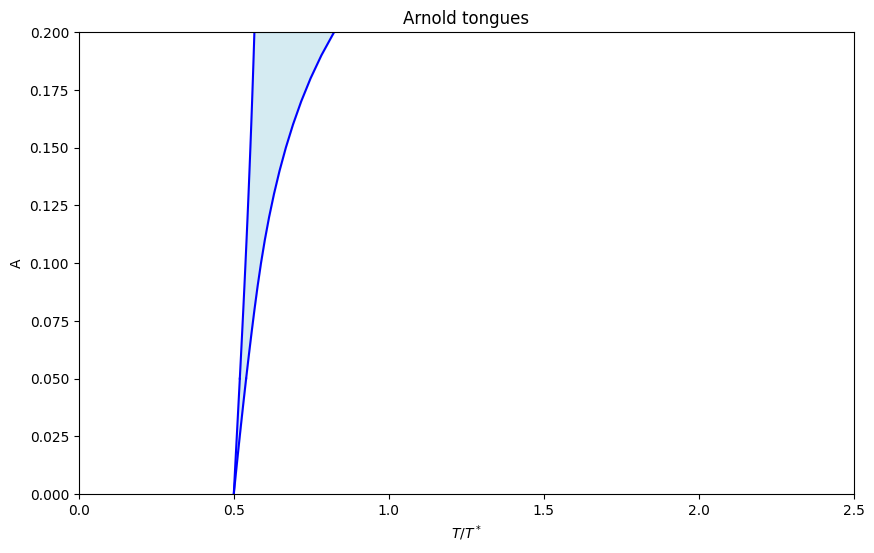

In [38]:
# The following code calculates the 1:2 Arnold tongue for pulsatile inputs. 
#The explanation of the method can be found in the appendix of the written thesis.
# Number of iterations for upward search
num_iterations_up_r = 16  

# Initialize lists to store results
T_values_right = []
A_values_right = []

# Initial value for A
A = 0.05

# Initial conditions
initial_guess = [6.857, 0.519 * Period]

# Function to define the root-finding conditions
def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Iterate to find new points
for i in range(num_iterations_up_r):
    # Use root to find a solution
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the solution
    theta_solution, T_solution = solution.x

    # Store values in lists
    T_values_right.append(T_solution / Period)  # Save normalized T
    A_values_right.append(A)  # Save A

    # Update for the next iteration
    A += 0.01
    initial_guess = [theta_solution, T_solution]

# Downward iterations for right branch
num_iterations_down_r = 6
A = 0.05
initial_guess = [6.857, 0.519 * Period]

for i in range(num_iterations_down_r):
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)
    theta_solution, T_solution = solution.x
    T_values_right.append(T_solution / Period)
    A_values_right.append(A)
    A -= 0.01
    initial_guess = [theta_solution, T_solution]

# Number of iterations for upward search (left branch)
num_iterations_up_left = 16
T_values = []
A_values = []

A = 0.05
initial_guess = [12.16, 0.54 * Period]

for i in range(num_iterations_up_left):
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)
    theta_solution, T_solution = solution.x
    T_values.append(T_solution / Period)
    A_values.append(A)
    A += 0.01
    initial_guess = [theta_solution, T_solution]

# Downward iterations for left branch
num_iterations_down_left = 6
A = 0.05
initial_guess = [12.16, 0.54 * Period]

for i in range(num_iterations_down_left):
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)
    theta_solution, T_solution = solution.x
    T_values.append(T_solution / Period)
    A_values.append(A)
    A -= 0.01
    initial_guess = [theta_solution, T_solution]

# Create a common set of points for the A-axis
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves to common A points
interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)

plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)

# Add labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Save data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_inh_1_2_inf.npy", T_values_left_interp)
np.save("T_values_right_interp_inh_1_2_inf.npy", T_values_right_interp)


### Computation of Arnold tongues for $\kappa \neq \infty$

In [23]:
import numpy as np
from scipy.optimize import fsolve

# Assuming T and A are defined
# Example: T = 1.0, A = 0.05 (adjust these as needed)
T = 2.23 * Period
A = 0.05

# Define the function `stroboscopic_map_theta` that evaluates `stroboscopic_map` for theta
# Here, `stroboscopic_map` and `interp_orbit_iPRC` must be defined in your environment
stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)

# Define the condition we want to solve: stroboscopic_map_theta(theta) - theta = 0
def fixed_point_condition(theta):
    return stroboscopic_map_theta(theta) - theta

# Use an initial guess for the search (adjust as needed)
initial_theta = 0  # Reasonable initial guess for theta

# Find the value of theta that satisfies the condition using fsolve
theta_solution = fsolve(fixed_point_condition, initial_theta)[0]

# Display the result
print("Value of theta found:", theta_solution)

# Verify the condition
verification = fixed_point_condition(theta_solution)
print("Verification (should be close to 0):", verification)


Valor de theta encontrado: 0.2676358056920071
Verificación (debe ser cercano a 0): -6.982359135321303e-12


In [24]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta


T = 2.23*Period

# Initial guess for [theta, A]
initial_guess = [0.267, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)


def phase_conditions_root_A(vars):
    theta, T = vars  # Unpack variables

    
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

A = 0.05

# Initial guess for [theta, A]
initial_guess_2 = [13.27, Period-0.04]
solution_2=root(phase_conditions_root_A,initial_guess_2, method='hybr', tol=1e-8)
# Extract the result
theta_solution, A_solution = solution.x
theta_solution_2, T_solution_2 = solution_2.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Check conditions by evaluating phase_conditions_root at the solution
cond12, cond22 = phase_conditions_root_A([theta_solution_2, T_solution_2])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution_2}")
print(f"T = {T_solution_2}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond12}")
print(f"Condition 2 (dPhi/dT - 1): {cond22}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")


Solution found:
theta = 1.1998167711103143
A = 0.04902943004671273

Verification of conditions:
Condition 1 (Phi_T - theta): -6.788887230158025e-10
Condition 2 (dPhi/dT - 1): 1.2219592004925062e-09
Solution found:
theta = 13.16303908401493
T = 24.19459217932236

Verification of conditions:
Condition 1 (Phi_T - theta): 5.939071456850797e-11
Condition 2 (dPhi/dT - 1): -5.539845249202813e-10

Both conditions are satisfied within the specified tolerance.


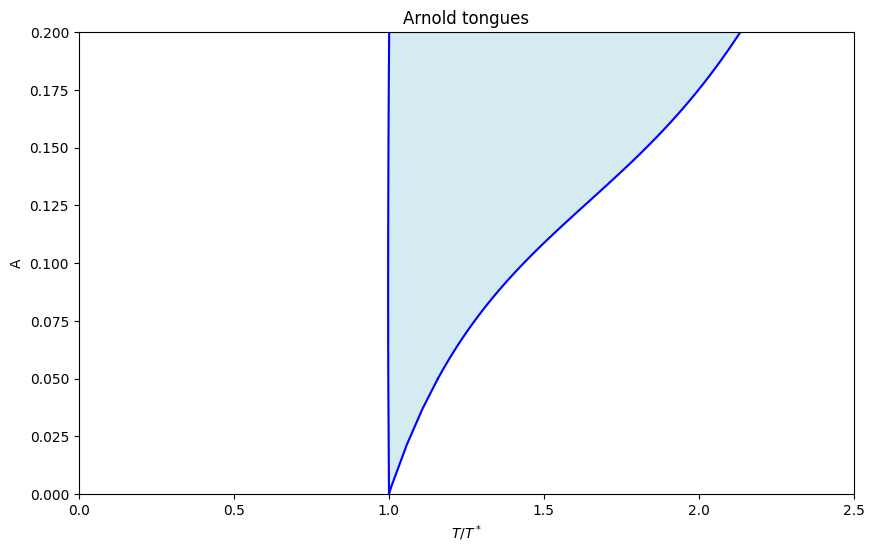

In [21]:
#COMPUTATION OF THE 1:1 ARNOLD TONGUE
import numpy as np
from scipy.optimize import root
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define the step size h
h = 0.00001  # The step size you desire
num_iterations_up_r = 16  # Number of iterations you desire

# Initialize lists to store the results
T_values_right = []
A_values_right = []

# Initial conditions
initial_guess = [13.27, 0.05]
initial_guess_A = [13.27, Period - 0.04]
A = 0.05

# Function to find roots
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

def phase_conditions_root_A(vars):
    theta, T = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution_A = root(phase_conditions_root_A, initial_guess_A, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution_A, T_solution_A = solution_A.x

    # Store the values in the lists
    T_values_right.append(T_solution_A / Period)  # Save normalized T
    A_values_right.append(A)    # Save A

    # Prepare the new T
    A += 0.01  # Increment A
    initial_guess_A = [theta_solution_A, T_solution_A]  # Use the found solution as a new initial point

# Adjust the step size and set iterations for the downward process
h = 0.005
num_iterations_down_r = 5
T = Period - 0.04
# Initial conditions
initial_guess = [13.27, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_right.append(T / Period)  # Save normalized T
    A_values_right.append(A_solution)    # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as a new initial point

# Adjust the step size for the upward process
h = 0.01  # The step size you desire
num_iterations_up_left = 100  # Number of iterations you desire

# Initialize lists to store the results
T_values = []
A_values = []

# Initializing T to 95% of Period
T = 1.158 * Period

# Initial conditions
initial_guess = [0.97, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values.append(T / Period)  # Save normalized T
    A_values.append(A_solution)    # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as a new initial point

# Adjust the step size for the downward process
h = 0.05
num_iterations_down_left = 5
T = 1.158 * Period
# Initial conditions
initial_guess = [0.97, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values.append(T / Period)  # Save normalized T
    A_values.append(A_solution)    # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as a new initial point

# Create a common set of points for the y-axis (A), for example, from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points in terms of A
interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common A points
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)

# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)

# Additional labels and configurations
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Save the data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_minus.npy", T_values_left_interp)
np.save("T_values_right_interp_minus.npy", T_values_right_interp)


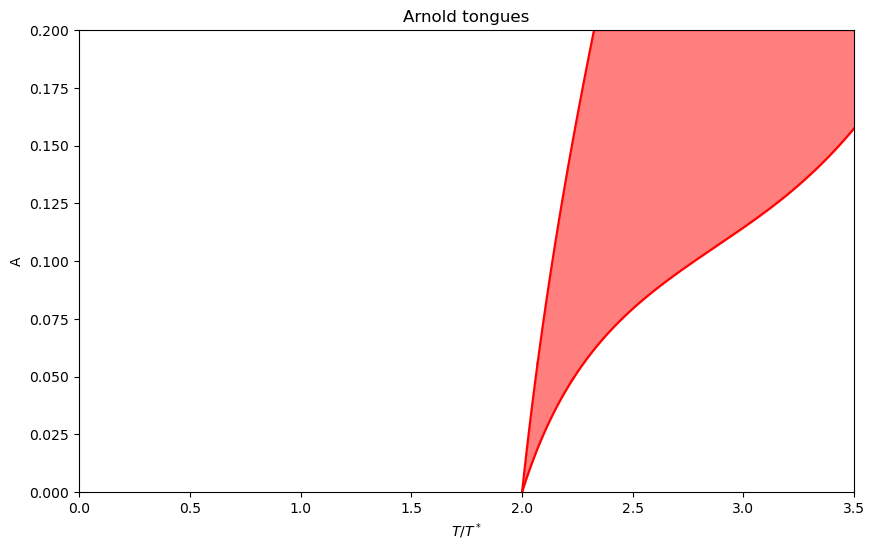

In [144]:
#COMPUTATION OF THE 2:1 ARNOLD TONGUE
# Set the step increment h
h = 0.01  # The step size you want
num_iterations_right = 30  # Number of iterations you want

# Initialize lists to store the results
T_values_right_2 = []
A_values_right_2 = []

# Initialize T to 95% of Period
T = 2.07 * Period

# Initial conditions
initial_guess = [15.59, 0.05]

# Function to find roots
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_right):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_right_2.append(T / Period)  # Save normalized T
    A_values_right_2.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Adjust the step size and set iterations for the downward process
h = 0.01  # The step size you want
num_iterations_down = 15  # Number of iterations you want

# Initialize T to 95% of Period
T = 2.07 * Period

# Initial conditions
initial_guess = [15.59, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_right_2.append(T / Period)  # Save normalized T
    A_values_right_2.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Set the step increment h for the leftward process
h = 0.01  # The step size you want
num_iterations_left = 150  # Number of iterations you want

# Initialize lists to store the results
T_values_left_2 = []
A_values_left_2 = []

# Initialize T to 95% of Period
T = 2.23 * Period

# Initial conditions
initial_guess = [0.267, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_left_2.append(T / Period)  # Save normalized T
    A_values_left_2.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Adjust the step size for the downward process
h = 0.005  # The step size you want
num_iterations_down = 50  # Number of iterations you want

# Initialize T to 95% of Period
T = 2.23 * Period

# Initial conditions
initial_guess = [0.267, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_left_2.append(T / Period)  # Save normalized T
    A_values_left_2.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Interpolate data for Arnold tongues graphs
A_common = np.linspace(0, 0.2, 200)
interp_left_2 = interp1d(A_values_left_2, T_values_left_2, bounds_error=False, fill_value="extrapolate")
interp_right_2 = interp1d(A_values_right_2, T_values_right_2, bounds_error=False, fill_value="extrapolate")
T_values_left_interp_2 = interp_left_2(A_common)
T_values_right_interp_2 = interp_right_2(A_common)

# Plot the results
plt.figure(figsize=(10, 6))
plt.xlim(0, 3.5)
plt.ylim(0, 0.2)
plt.plot(T_values_left_2[0:num_iterations_left], A_values_left_2[0:num_iterations_left], color='red')
plt.plot(T_values_left_2[num_iterations_left:], A_values_left_2[num_iterations_left:], color='red')
plt.plot(T_values_right_2[0:num_iterations_right], A_values_right_2[0:num_iterations_right], color='red')
plt.plot(T_values_right_2[num_iterations_right:], A_values_right_2[num_iterations_right:], color='red')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='red', alpha=0.5)

plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Save the interpolated data to .npy files
np.save("T_values_left_interp_2_minus.npy", T_values_left_interp_2)
np.save("T_values_right_interp_2_minus.npy", T_values_right_interp_2)


In [104]:
# Define the function for P^2(theta) in order to find the 1:2 Arnold tongue
def stroboscopic_map_squared(x, A, T,interp_orbit_iPRC):
    # Apply stroboscopic_map twice
    first_application = stroboscopic_map(x, A, T, interp_orbit_iPRC)
    second_application = stroboscopic_map(first_application, A, T, interp_orbit_iPRC)
    return second_application

In [136]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta_squared = lambda theta: stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta_squared)(theta)
    return dPhi_dtheta


T = 0.538*Period

# Initial guess for [theta, A]
initial_guess = [1, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_squared(vars):
    theta, A = vars  # Unpack variables

    
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root_squared([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")

Solution found:
theta = 1.327403661231587
A = 0.049310399030175214

Verification of conditions:
Condition 1 (Phi_T - theta): 2.297051437949449e-12
Condition 2 (dPhi/dT - 1): -1.175263220076772e-10

Both conditions are satisfied within the specified tolerance.


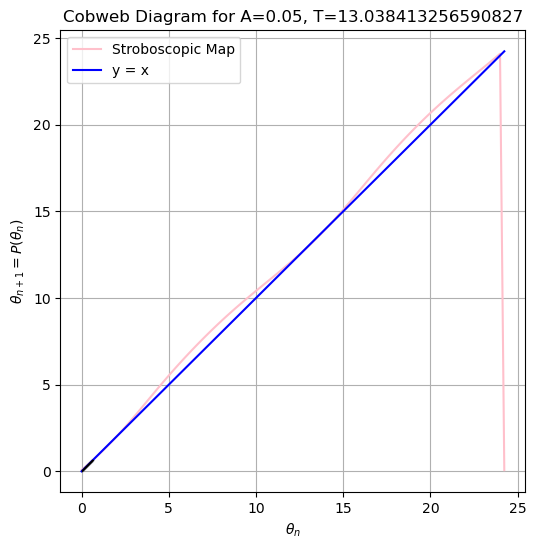

In [135]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot_squared(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map_squared(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map_squared(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot_squared(0, 0.538*Period, 0.05, 200)

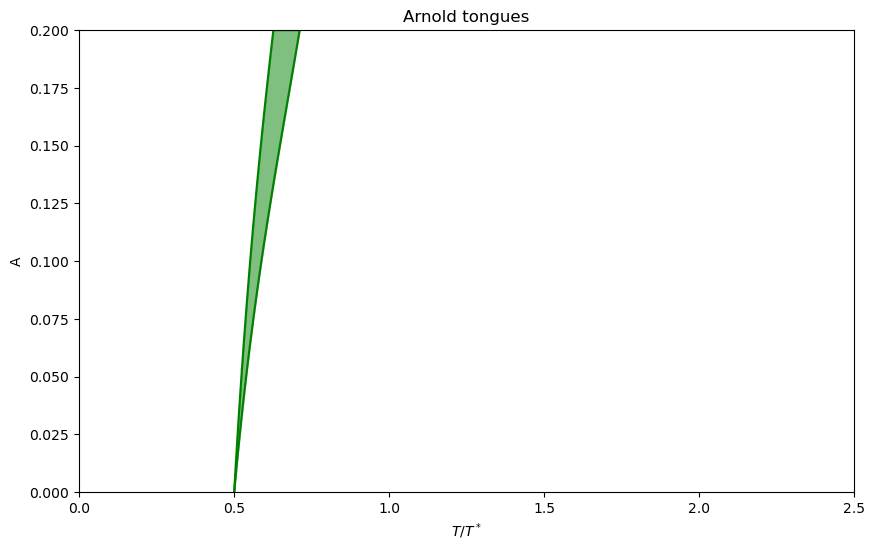

In [145]:
#COMPUTATION OF THE 1:2 ARNOLD TONGUE
# Set the step increment h
h = 0.005  # The step size you want
num_iterations_right = 25  # Number of iterations you want

# Initialize lists to store the results
T_values_right_1 = []
A_values_right_1 = []

# Initialize T to 95% of Period
T = 0.525 * Period

# Initial conditions
initial_guess = [22, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_squared(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_right):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_right_1.append(T / Period)  # Save normalized T
    A_values_right_1.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Adjust the step size and set iterations for the downward process
h = 0.005  # The step size you want
num_iterations_down = 10  # Number of iterations you want

# Initialize T to 95% of Period
T = 0.525 * Period

# Initial conditions
initial_guess = [22, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_right_1.append(T / Period)  # Save normalized T
    A_values_right_1.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Set the step increment h for the leftward process
h = 0.005  # The step size you want
num_iterations_left = 45  # Number of iterations you want

# Initialize lists to store the results
T_values_left_1 = []
A_values_left_1 = []

# Initialize T to 95% of Period
T = 0.538 * Period

# Initial conditions
initial_guess = [1, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_left_1.append(T / Period)  # Save normalized T
    A_values_left_1.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Adjust the step size for the downward process
h = 0.005  # The step size you want
num_iterations_down = 15  # Number of iterations you want

# Initialize T to 95% of Period
T = 0.538 * Period

# Initial conditions
initial_guess = [1, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store the values in the lists
    T_values_left_1.append(T / Period)  # Save normalized T
    A_values_left_1.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the found solution as the new initial point

# Interpolate data for Arnold tongues graphs
A_common = np.linspace(0, 0.2, 200)
interp_left_1 = interp1d(A_values_left_1, T_values_left_1, bounds_error=False, fill_value="extrapolate")
interp_right_1 = interp1d(A_values_right_1, T_values_right_1, bounds_error=False, fill_value="extrapolate")
T_values_left_interp_1 = interp_left_1(A_common)
T_values_right_interp_1 = interp_right_1(A_common)

# Plot the results
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_left_1[0:num_iterations_left], A_values_left_1[0:num_iterations_left], color='green')
plt.plot(T_values_left_1[num_iterations_left:], A_values_left_1[num_iterations_left:], color='green')
plt.plot(T_values_right_1[0:num_iterations_right], A_values_right_1[0:num_iterations_right], color='green')
plt.plot(T_values_right_1[num_iterations_right:], A_values_right_1[num_iterations_right:], color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='green', alpha=0.5)

plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

# Save the interpolated data to .npy files
np.save("T_values_left_interp_1_minus.npy", T_values_left_interp_1)
np.save("T_values_right_interp_1_minus.npy", T_values_right_interp_1)


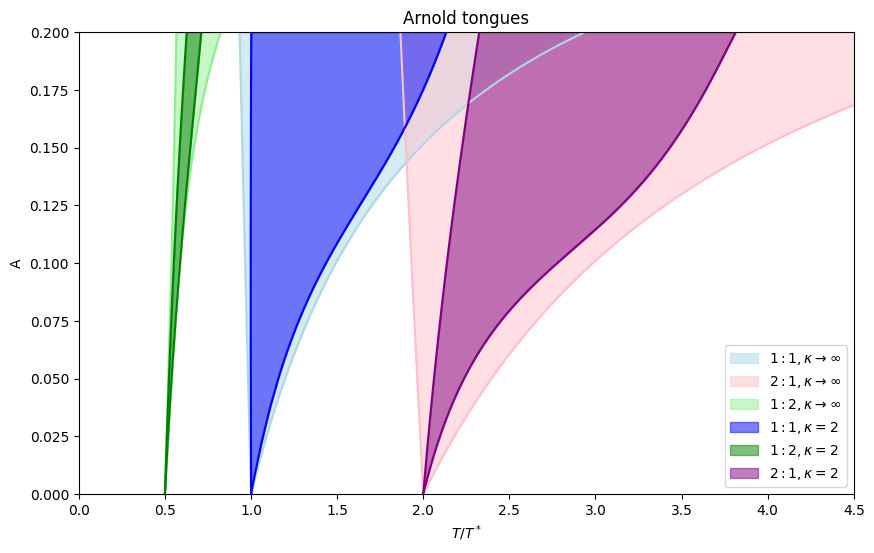

In [42]:
#FINALS ARNOLD TONGUES: k=2, k=infinity
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define time points
time_points = np.linspace(0, Period, 1000)
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC

# Extract and calculate Z components
Z_values = interp_values[1] + interp_values[5]
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)

# Define A and calculate T/T* for different scales
AA_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 - AA_values * Zmax
T_over_Tstar_min = 1 - AA_values * Zmin
T_over_Tstar_max_2 = (1/2) * (1 - AA_values * Zmax)
T_over_Tstar_min_2 = (1/2) * (1 - AA_values * Zmin)

# Interpolate data for Arnold tongues plots
T_values_left_interp_2 = np.load("T_values_left_interp_2_minus.npy")
T_values_right_interp_2 = np.load("T_values_right_interp_2_minus.npy")
T_values_left_interp_1 = np.load("T_values_left_interp_1_minus.npy")
T_values_right_interp_1 = np.load("T_values_right_interp_1_minus.npy")
A_common = np.load("A_common.npy")
T_values_left_interp = np.load("T_values_left_interp_minus.npy")
T_values_right_interp = np.load("T_values_right_interp_minus.npy")
T_values_right = np.load("T_values_right_interp_inh_1_2_inf.npy")
T_values_left = np.load("T_values_left_interp_inh_1_2_inf.npy")

# Combine and plot
plt.figure(figsize=(10, 6))

# Fill and contour the first set of curves
plt.fill_betweenx(AA_values, 1/T_over_Tstar_min, 1/T_over_Tstar_max, color='lightblue', alpha=0.5, label=r'$1:1, \kappa \rightarrow \infty$')
plt.plot(1/T_over_Tstar_max, AA_values, color='lightblue')
plt.plot(1/T_over_Tstar_min, AA_values, color='lightblue')
plt.fill_betweenx(AA_values, 1/T_over_Tstar_min_2, 1/T_over_Tstar_max_2, color='pink', alpha=0.5, label=r'$2:1, \kappa \rightarrow \infty$')
plt.plot(1/T_over_Tstar_max_2, AA_values, color='pink')
plt.plot(1/T_over_Tstar_min_2, AA_values, color='pink')
plt.fill_betweenx(A_common, T_values_right, T_values_left, color='lightgreen', alpha=0.5, label=r'$1:2, \kappa \rightarrow \infty$')
plt.plot(T_values_right, A_common, color='lightgreen')
plt.plot(T_values_left, A_common, color='lightgreen')

# Plot Arnold tongues and fill between 1:1 interpolated curves
plt.plot(T_values_left_interp, A_common, color='blue')
plt.plot(T_values_right_interp, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='blue', alpha=0.5, label=r'$1:1, \kappa = 2$')

# Plot 1:2
plt.plot(T_values_left_interp_1, A_common, color='green')
plt.plot(T_values_right_interp_1, A_common, color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='green', alpha=0.5, label=r'$1:2, \kappa = 2$')

# Plot 2:1
plt.plot(T_values_left_interp_2, A_common, color='purple')
plt.plot(T_values_right_interp_2, A_common, color='purple')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='purple', alpha=0.5, label=r'$2:1, \kappa = 2$')

# Final plot settings
plt.xlim(0, 4.5)
plt.ylim(0, 0.2)
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.legend(loc='best')
plt.grid(False)
plt.show()


### CTC measures

t_inh (time of max r_i after transient): 18.91001372031657
t_p (time of max p after transient): 12.118696308841688
Delta_tau: 0.2802280228022802


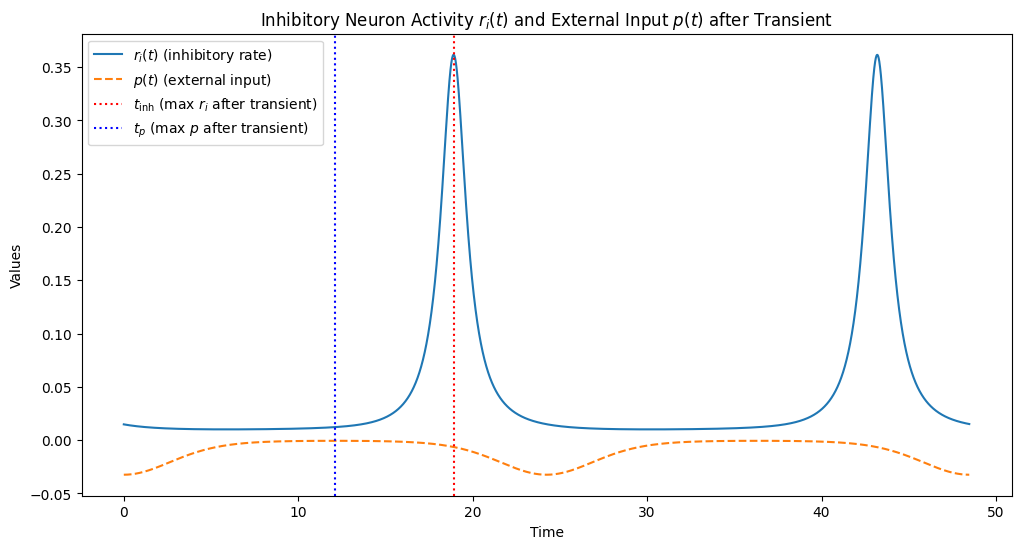

In [27]:
#Pre computation of Delta tau
# Solve the ODE system
# Time span for integration
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")
t = np.linspace(0, 15*Period, 20000)
T=Period
A=0.01
# Solve the system of equations
atol = 1e-17
rtol = 1e-13
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)

# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)


t= np.linspace(0, 40 * T, 100000) 
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
P_2=sol[-1]
t= np.linspace(0, 2*T, 10000)
sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)
        
# Ignore the initial transient by selecting only the times after transient_time
t_after_transient = t[(t <= T)]
#r_i_after_transient = r_i[t >= transient_time]
p_after_transient = p_t[(t <= T)]
# Find the time t_p of the maximum of p after the transient
t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
# Limit search for r_i to one period T after t_p
t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
# Find the maximum of r_i within this period
t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
# Calculate Delta_tau
Delta_tau = (t_inh - t_p) / T


# Output the result
print(f"t_inh (time of max r_i after transient): {t_inh}")
print(f"t_p (time of max p after transient): {t_p}")
print(f"Delta_tau: {Delta_tau}")


# Optional: Plotting r_i and p to visualize
plt.figure(figsize=(12, 6))
plt.plot(t, r_i, label=r'$r_i(t)$ (inhibitory rate)')
plt.plot(t, A*p_t, label=r'$p(t)$ (external input)', linestyle='--')
plt.axvline(t_inh, color='red', linestyle=':', label=r'$t_{\text{inh}}$ (max $r_i$ after transient)')
plt.axvline(t_p, color='blue', linestyle=':', label=r'$t_p$ (max $p$ after transient)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Inhibitory Neuron Activity $r_i(t)$ and External Input $p(t)$ after Transient')
plt.legend()
plt.show()

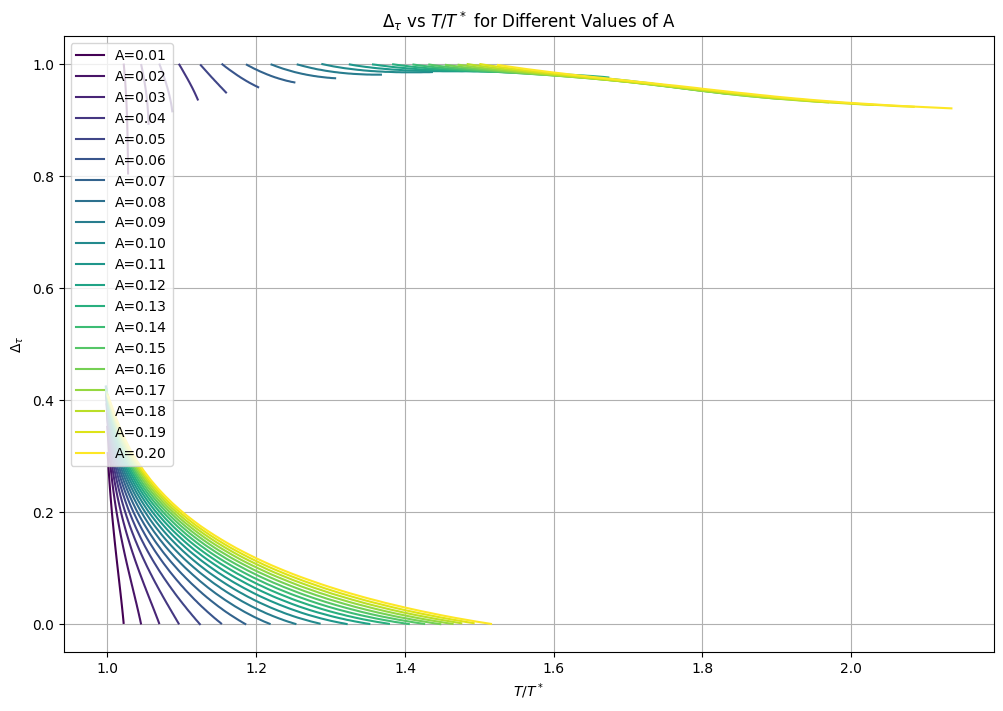

In [28]:
#Computation of Delta tau
from scipy.interpolate import interp1d
t = np.linspace(0, 30 * Period, 100000)  # Adjust time range and resolution as needed
A_values= np.linspace(0.01,0.2,20)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    print(A)
    # Interpolate bounds for T based on A
    T_left = interp_left(A)*Period
    T_right = interp_right(A)*Period
    
    # Generate equidistant values of T within bounds
    T_values = np.linspace(T_left+0.001*Period, T_right, 120)
    
    
    # Store Delta_tau values for current A
    delta_tau_values = []
    T_ratio_values = []
    # Listas para almacenar los grupos separados
    T_ratio_plus = []     # Para T_ratio con delta_tau > 0.6
    Delta_tau_plus = []   # Para delta_tau > 0.6
    T_ratio_minus = []    # Para T_ratio con delta_tau <= 0.6
    Delta_tau_minus = []  # Para delta_tau <= 0.6

    for T in T_values:
        # Simulate the system with current A and T
        t= np.linspace(0, 60 * T, 1000000) 
        sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol[-1]
        t= np.linspace(0, 2*T, 10000)
        sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau = (t_inh - t_p) / T
        T_ratio = T / Period
        
        # Store values for plotting
        delta_tau_values.append(Delta_tau)
        T_ratio_values.append(T_ratio)
        

    # Separación de los valores
    for delta_tau, T_ratio in zip(delta_tau_values, T_ratio_values):
        if delta_tau > 0.6:
            Delta_tau_plus.append(delta_tau)
            T_ratio_plus.append(T_ratio)
        else:
            Delta_tau_minus.append(delta_tau)
            T_ratio_minus.append(T_ratio)

    # Plot Delta_tau vs T / Period for the current A
    plt.plot(T_ratio_plus, Delta_tau_plus, label=f'A={A:.2f}', color=colors[i])
    plt.plot(T_ratio_minus, Delta_tau_minus, color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\tau}$')
plt.legend(loc='upper left')
plt.title(r'$\Delta_{\tau}$ vs $T / T^*$ for Different Values of A')
plt.grid(True)
plt.show()

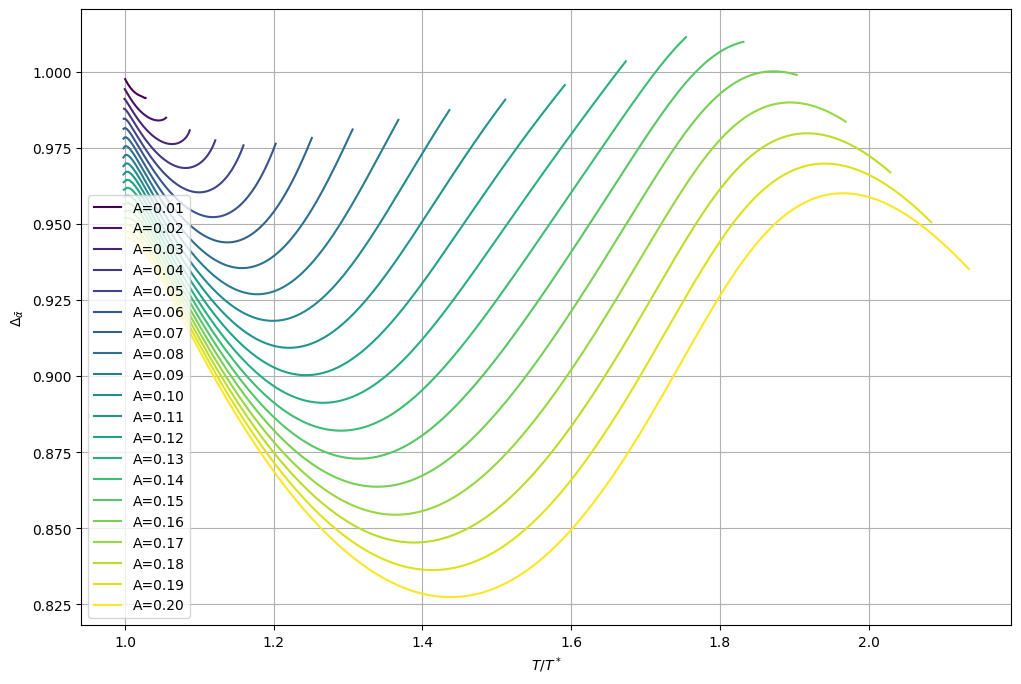

In [23]:
#Computation of Delta Bar Alpha
import numpy as np
from scipy.integrate import odeint, trapezoid
import matplotlib.pyplot as plt
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")

t = np.linspace(0, 40 * Period,1000000)
sol_0 = odeint(neural_network, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
P_2=sol_0[-1]
t = np.linspace(0,  Period,10000)
sol_0 = odeint(neural_network, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary
# Compute R_bar_0 (mean over one period T_star)
R_bar_0 = trapezoid(r_e_0, dx=Period/len(t)) / Period
# Setup parameters for plotting
A_values = np.linspace(0.01, 0.2, 20)  # Range of perturbation values
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

plt.figure(figsize=(12, 8))

for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
    T_left = interp_left(A) * Period
    T_right = interp_right(A) * Period
    T_values = np.linspace(T_left+0.001*Period, T_right, 150)

    delta_bar_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        # Solve system with perturbation A
        t = np.linspace(0, 40 * T,1000000)
        sol_A = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol_A[-1]
        t = np.linspace(0, T,10000)
        sol_A = odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_bar_A = trapezoid(r_e_A, dx=T/len(t)) / T
        #print(R_bar_A)
        # Compute Delta_bar_alpha
        Delta_bar_alpha = R_bar_A / R_bar_0
        T_ratio = T / Period

        # Store values for plotting
        delta_bar_alpha_values.append(Delta_bar_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_bar_alpha_values, label=f'A={A:.2f}', color=colors[i])

# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\bar{\alpha}}$')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

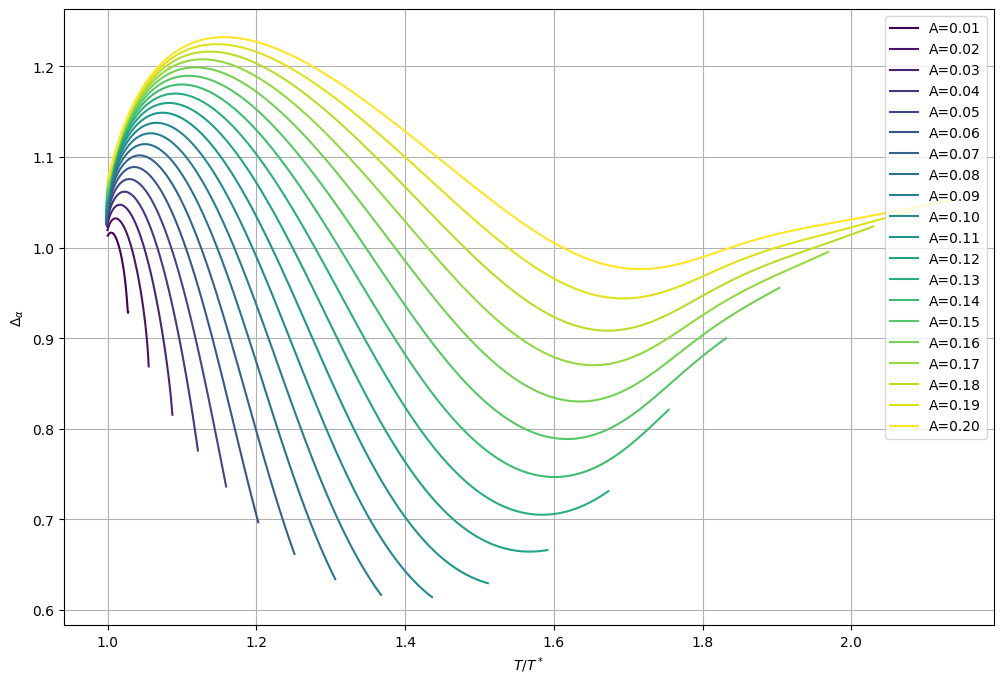

In [30]:
#Comptation of Delta Alpha
t = np.linspace(0, 60 * Period, 1000000)  # Adjust time range and resolution as needed

sol_0 = odeint(neural_network, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
t = np.linspace(0, Period, 100000)  # Adjust time range and resolution as needed
P_2=sol_0[-1]
sol_0 = odeint(neural_network, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary

# Compute R_bar_0 (mean over one period T_star)
R_0 = np.max(r_e_0)

A_values= np.linspace(0.01,0.2,20)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
     # Interpolate bounds for T based on A
    T_left = interp_left(A) * Period
    T_right = interp_right(A) * Period
    T_values = np.linspace(T_left+0.001*Period, T_right, 120)

    delta_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        # Solve system with perturbation A
        t=np.linspace(0, 60 * T, 1000000)
        sol_A = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        #plt.plot(t,sol_A[:,0],label=f'{T}')
        P_2=sol_A[-1]
        t=np.linspace(0, T, 100000)
        sol_A = odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_A = np.max(r_e_A)
        
        #print(R_bar_A)
        # Compute Delta_bar_alpha
        Delta_alpha = R_A / R_0
        T_ratio = T / Period

        # Store values for plotting
        delta_alpha_values.append(Delta_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_alpha_values, label=f'A={A:.2f}', color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\alpha}$')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

t_inh (time of max r_i after transient): 18.91001372031657
t_p (time of max p after transient): 0.0
Delta_tau: 0.7802780278027802


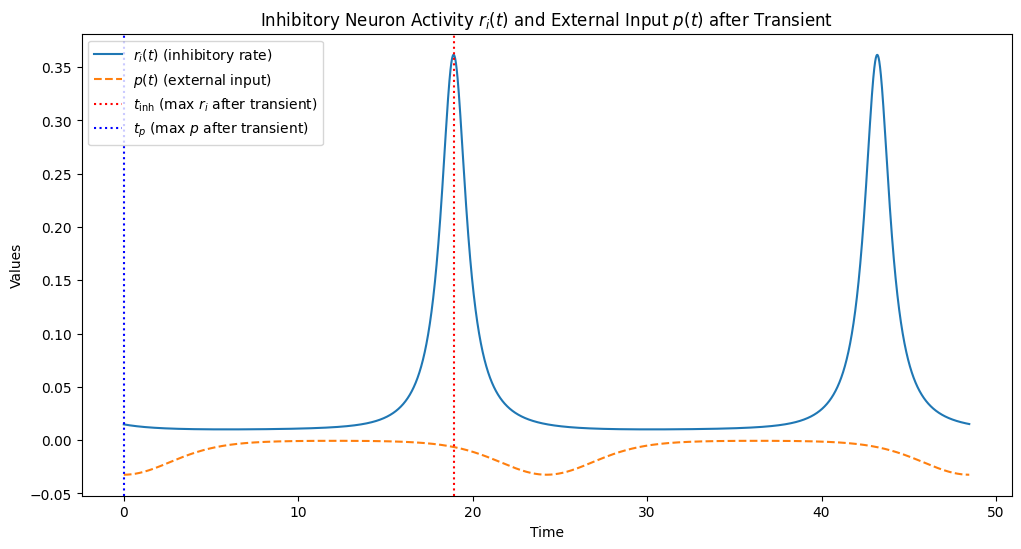

In [19]:
#Pre-computation of Delta tau min
# Solve the ODE system
# Time span for integration
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")
t = np.linspace(0, 15*Period, 20000)
T=Period
A=0.01
# Solve the system of equations
atol = 1e-17
rtol = 1e-13
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)

# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)


t= np.linspace(0, 40 * T, 100000) 
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
P_2=sol[-1]
t= np.linspace(0, 2*T, 10000)
sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)
        
# Ignore the initial transient by selecting only the times after transient_time
t_after_transient = t[(t <= T)]
#r_i_after_transient = r_i[t >= transient_time]
p_after_transient = p_t[(t <= T)]
# Find the time t_p of the maximum of p after the transient
t_p_index = np.argmin(p_after_transient)  # Index of max p after transient
t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
# Limit search for r_i to one period T after t_p
t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
# Find the maximum of r_i within this period
t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
# Calculate Delta_tau
Delta_tau = (t_inh - t_p) / T


# Output the result
print(f"t_inh (time of max r_i after transient): {t_inh}")
print(f"t_p (time of max p after transient): {t_p}")
print(f"Delta_tau: {Delta_tau}")


# Optional: Plotting r_i and p to visualize
plt.figure(figsize=(12, 6))
plt.plot(t, r_i, label=r'$r_i(t)$ (inhibitory rate)')
plt.plot(t, A*p_t, label=r'$p(t)$ (external input)', linestyle='--')
plt.axvline(t_inh, color='red', linestyle=':', label=r'$t_{\text{inh}}$ (max $r_i$ after transient)')
plt.axvline(t_p, color='blue', linestyle=':', label=r'$t_p$ (max $p$ after transient)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Inhibitory Neuron Activity $r_i(t)$ and External Input $p(t)$ after Transient')
plt.legend()
plt.show()

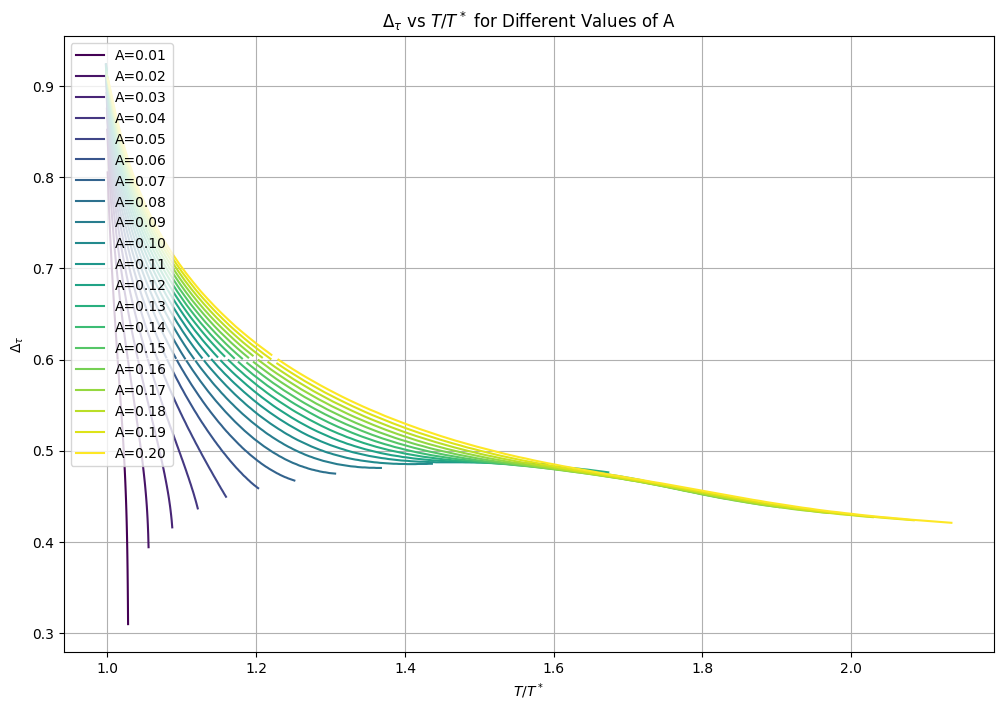

In [20]:
#Computation of Delta tau with respect to the min
from scipy.interpolate import interp1d
t = np.linspace(0, 30 * Period, 100000)  # Adjust time range and resolution as needed
A_values= np.linspace(0.01,0.2,20)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
    T_left = interp_left(A)*Period
    T_right = interp_right(A)*Period
    
    # Generate equidistant values of T within bounds
    T_values = np.linspace(T_left+0.001*Period, T_right, 120)
    
    
    # Store Delta_tau values for current A
    delta_tau_values = []
    T_ratio_values = []
    # Listas para almacenar los grupos separados
    T_ratio_plus = []     # Para T_ratio con delta_tau > 0.6
    Delta_tau_plus = []   # Para delta_tau > 0.6
    T_ratio_minus = []    # Para T_ratio con delta_tau <= 0.6
    Delta_tau_minus = []  # Para delta_tau <= 0.6

    for T in T_values:
        # Simulate the system with current A and T
        t= np.linspace(0, 60 * T, 1000000) 
        sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol[-1]
        t= np.linspace(0, 2*T, 10000)
        sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmin(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau = (t_inh - t_p) / T
        T_ratio = T / Period
        
        # Store values for plotting
        delta_tau_values.append(Delta_tau)
        T_ratio_values.append(T_ratio)
        

    # Separación de los valores
    for delta_tau, T_ratio in zip(delta_tau_values, T_ratio_values):
        if delta_tau > 0.6:
            Delta_tau_plus.append(delta_tau)
            T_ratio_plus.append(T_ratio)
        else:
            Delta_tau_minus.append(delta_tau)
            T_ratio_minus.append(T_ratio)

    # Plot Delta_tau vs T / Period for the current A
    plt.plot(T_ratio_plus, Delta_tau_plus, label=f'A={A:.2f}', color=colors[i])
    plt.plot(T_ratio_minus, Delta_tau_minus, color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\tau}$')
plt.legend(loc='upper left')
plt.title(r'$\Delta_{\tau}$ vs $T / T^*$ for Different Values of A')
plt.grid(True)
plt.show()